In [1]:
! pip install pandas seaborn imblearn -q

## Brief Introduction
____
The key objective of this notebook is to provide a simple guide to impute most variables in application_train dataset. After this process, I also used PCA to deal with only a few variables. Turns out that only four principal components are necessary to explain almost 100% of the data's variance. This notebook is intended to help kagglers use other algorithms that can't deal well with missing values. I tried to make the imputation as intuitive and correct as possible, but if someone disagree with the values I chose and/or  have a better value to impute, please feel free to comment and help me improve this notebook!

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
import numpy as np

app_train = pd.read_csv('../data/application_train.csv')
# application_test= pd.read_csv('../data/application_test.csv')
bureau = pd.read_csv('../data/bureau.csv')
# bureau_balance = pd.read_csv('../data/bureau_balance.csv')
# POS_CASH_balance = pd.read_csv('../data/POS_CASH_balance.csv')
# credit_card_balance = pd.read_csv('../data/credit_card_balance.csv')
# previous_application = pd.read_csv('../data/previous_application.csv')
# installments_payments = pd.read_csv('../data/installments_payments.csv')

In [3]:
df = app_train

df = df.join(bureau, how='left', on='SK_ID_CURR', rsuffix="_BUREAU")

df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_BUREAU
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-2320.0,NaN,0,58590.99,0.0,NaN,0.0,Consumer credit,-762,12681.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,-1090.0,NaN,0,91881.00,0.0,0.0,0.0,Consumer credit,-1085,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,-1275.0,NaN,0,183829.50,0.0,0.0,0.0,Consumer credit,-1266,12681.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,-1543.0,NaN,0,45153.00,0.0,NaN,0.0,Consumer credit,-1543,12681.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,-2103.0,NaN,0,699943.50,0.0,NaN,0.0,Car loan,-2101,NaN


## Dealing with missing values

In [4]:
null_values_apptr = df.isnull().sum()
null_values_apptr = null_values_apptr[null_values_apptr != 0].sort_values(ascending = False).reset_index() #only show rows with null values
null_values_apptr.columns = ["variable", "n_missing"]
null_values_apptr.head()

,variable,n_missing
0,COMMONAREA_MEDI,214865
1,COMMONAREA_AVG,214865
2,COMMONAREA_MODE,214865
3,NONLIVINGAPARTMENTS_AVG,213514
4,NONLIVINGAPARTMENTS_MODE,213514


There are several variables with "MODE", "AVG" or "MEDI" on it. In most cases, the number of missing values is exactly for all statistics belonging to a given feature. For instance, all variables with name "COMMONAREA" share the same number of null values. I think it is fairly safe to assume that those missing values actually represent the lack of that characteristic, so all clients with COMMONAREA features equal to zero probably don't live in a place that has a common area. Therefore I'll assign each and everyone of them the value of zero. 

In [5]:
for variable in null_values_apptr["variable"]:
    if (variable.endswith("MEDI")|variable.endswith("MODE")|variable.endswith("AVG")):
        df.loc[:,variable] = df.loc[:,variable].fillna(0)

I'll do the same for all variables related to Credit Bureau. As they are "Number of enquiries to Credit Bureau about the client \*some predefined period of time\*  before application", I assume that null quantities related to those variables are actually 0, meaning that no enquiries were made for that client.

In [6]:
for variable in null_values_apptr["variable"]:
    if (variable.startswith("AMT_REQ_CREDIT_BUREAU")):
        df.loc[:,variable] = df.loc[:,variable].fillna(0)

The "Social Circle" variables are a kind of mystery to me, but as they are a "number of observations" according to the columns dictionary, I feel that 0 is an appropriate value to impute as well, because no observations of client's social circle were made.

In [7]:
for variable in null_values_apptr["variable"]:
    if (variable.endswith("SOCIAL_CIRCLE")):
        df.loc[:,variable] = df.loc[:,variable].fillna(0)

Let's check for the remaining variables with missing values

In [8]:
#checking for remaining nulls:
null_values_apptr = df.isnull().sum()
null_values_apptr = null_values_apptr[null_values_apptr != 0].sort_values(ascending = False).reset_index() #only show rows with null values
null_values_apptr.columns = ["variable", "n_missing"]
#percentage of missing values on a given column
null_values_apptr["pct_missing"] = null_values_apptr.n_missing/len(df)
null_values_apptr

,variable,n_missing,pct_missing
0,AMT_CREDIT_MAX_OVERDUE,204422,0.664763
1,OWN_CAR_AGE,202929,0.659908
2,AMT_ANNUITY_BUREAU,202747,0.659316
3,EXT_SOURCE_1,173378,0.563811
4,DAYS_ENDDATE_FACT,112803,0.366826
5,AMT_CREDIT_SUM_LIMIT,107782,0.350498
6,OCCUPATION_TYPE,96391,0.313455
7,EXT_SOURCE_3,60965,0.198253
8,AMT_CREDIT_SUM_DEBT,46035,0.149702
9,DAYS_CREDIT_ENDDATE,19211,0.062473


There is a lot less variables we have to check one by one. 
## OWN_CAR_AGE
___

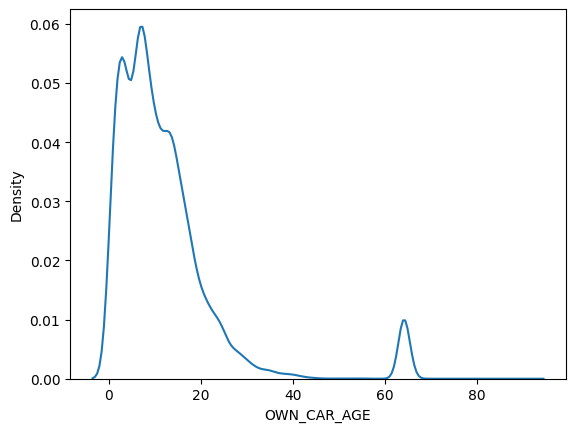

In [9]:
sns.kdeplot(app_train.OWN_CAR_AGE);

This variable is a bit tricky. Here there are two things that I can think about that null values may represent:
- null values mean that the client doesn't own a car
- null values mean that it is just missing information
- a mix of the two

I'll assume the first option, as 65% of missing data doesn't seem to indicate a failure in collecting the data. Maybe a small percentage of those NaN are really missing information, but I'll assume it will be a really small percentage. For customers without a car, there doesn't seem to be a reasonable and logical value to impute the car's age. To solve this, let's create a variable "own_car" and assign 1 to anyone who has a car and 0 otherwise.

In [10]:
df["OWN_CAR"] = 0
df.loc[app_train.OWN_CAR_AGE >= 0, "OWN_CAR"] = 1
df.loc[:,("OWN_CAR", "OWN_CAR_AGE")].head()

#dropping car age column
df = df.drop(columns=["OWN_CAR_AGE"])

### EXT SCORE variables
___
These variables are "normalized scores from external data sources".  So although the clients with missing values probably weren't scored, each customer should have a "ideal score", at least in theory. So we can't give them score 0 right away. Rather, let's see the distribution of all EXT SCOREs and impute case by case.

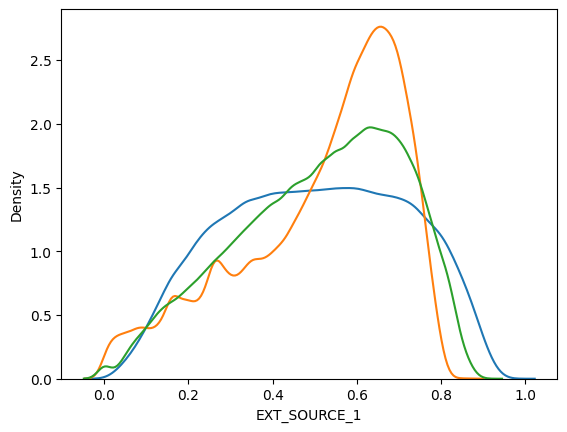

In [11]:
sns.kdeplot(df.EXT_SOURCE_1);
sns.kdeplot(df.EXT_SOURCE_2);
sns.kdeplot(df.EXT_SOURCE_3);

Source 1 has too much missing values, so imputation could potentially bias this variable. I prefer not to use it at all unless the algorithm can deal with null values by itself, like LightGBM. Source 2 has a smaller number of nulls and maybe using a ML algorithm would be the best shot to impute it, as imputing it with either mean or median values create a huge deformation on the distribution. For this version, I'll just remove it and mabe come back at a later time to deal with it properly. 
At last, Source 3 has just a small percentage of missing values and imputing it with the median value seems to be the best.

In [12]:
df.loc[:,"EXT_SOURCE_1"] = df.loc[:,"EXT_SOURCE_1"].fillna(df.EXT_SOURCE_1.median())
df.loc[:,"EXT_SOURCE_2"] = df.loc[:,"EXT_SOURCE_2"].fillna(df.EXT_SOURCE_2.median())
df.loc[:,"EXT_SOURCE_3"] = df.loc[:,"EXT_SOURCE_3"].fillna(df.EXT_SOURCE_3.median())
null_values_apptr = df.isnull().sum()
null_values_apptr = null_values_apptr[null_values_apptr != 0].sort_values(ascending = False).reset_index() #only show rows with null values
null_values_apptr.columns = ["variable", "n_missing"]
null_values_apptr

,variable,n_missing
0,AMT_CREDIT_MAX_OVERDUE,204422
1,AMT_ANNUITY_BUREAU,202747
2,DAYS_ENDDATE_FACT,112803
3,AMT_CREDIT_SUM_LIMIT,107782
4,OCCUPATION_TYPE,96391
5,AMT_CREDIT_SUM_DEBT,46035
6,DAYS_CREDIT_ENDDATE,19211
7,NAME_TYPE_SUITE,1292
8,AMT_GOODS_PRICE,278
9,AMT_ANNUITY,12


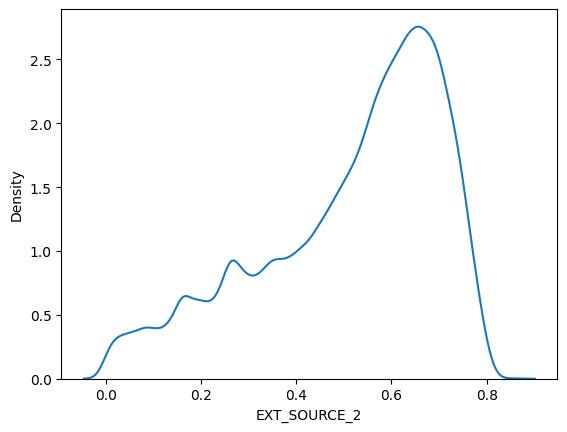

In [13]:
sns.kdeplot(df.EXT_SOURCE_2);
# sns.kdeplot(app_train.EXT_SOURCE_3);

The distribution remains almost the same, so it seems the median was a good choice indeed.

## OCCUPATION_TYPE
_____
This variable will be dealt a bit differently than the others. Inspired by [ISR's kernel](https://www.kaggle.com/isr1512/home-credit-expanded-detailed-data-analysis), I'll use the education level of each person with a missing value in Occupation.

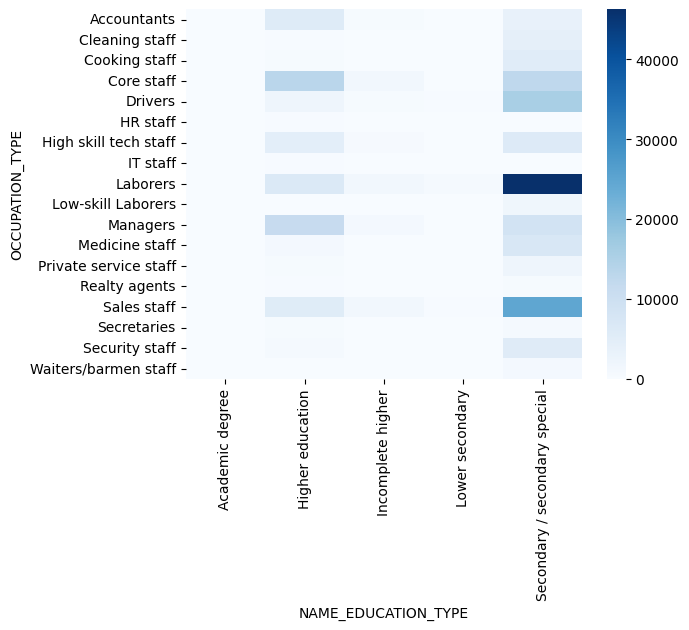

In [14]:
df.NAME_EDUCATION_TYPE.unique()
sns.heatmap(pd.crosstab(df.OCCUPATION_TYPE, df.NAME_EDUCATION_TYPE), cmap="Blues");

In [15]:
for education in df.NAME_EDUCATION_TYPE.unique():
    mode_to_impute = df[df.NAME_EDUCATION_TYPE == education].OCCUPATION_TYPE.mode()[0]
    df.loc[df.NAME_EDUCATION_TYPE == education, "OCCUPATION_TYPE"] = df.loc[df.NAME_EDUCATION_TYPE == education, "OCCUPATION_TYPE"].fillna(mode_to_impute)

In [16]:
null_values_apptr = df.isnull().sum()
null_values_apptr = null_values_apptr[null_values_apptr != 0].sort_values(ascending = False).reset_index() #only show rows with null values
null_values_apptr.columns = ["variable", "n_missing"]
null_values_apptr

,variable,n_missing
0,AMT_CREDIT_MAX_OVERDUE,204422
1,AMT_ANNUITY_BUREAU,202747
2,DAYS_ENDDATE_FACT,112803
3,AMT_CREDIT_SUM_LIMIT,107782
4,AMT_CREDIT_SUM_DEBT,46035
5,DAYS_CREDIT_ENDDATE,19211
6,NAME_TYPE_SUITE,1292
7,AMT_GOODS_PRICE,278
8,AMT_ANNUITY,12
9,CNT_FAM_MEMBERS,2


## NAME_TYPE_SUITE
___

<Axes: xlabel='count', ylabel='NAME_TYPE_SUITE'>

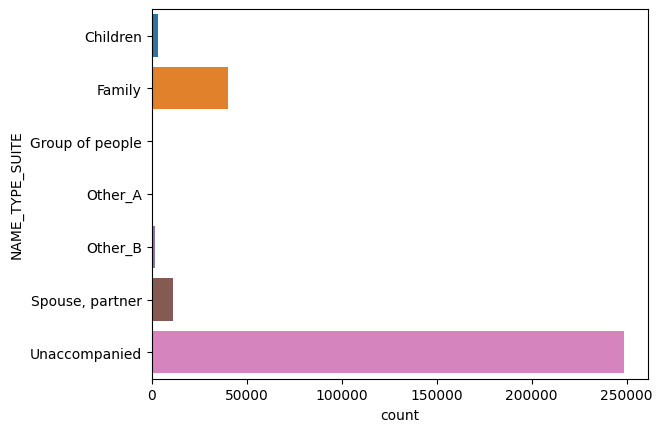

In [17]:
df.NAME_TYPE_SUITE = df.NAME_TYPE_SUITE.astype("category")
sns.countplot(y = df.NAME_TYPE_SUITE)

By far, most people are unaccompanied, so we will use this value to impute NAME_TYPE_SUITE.

In [18]:
df.NAME_TYPE_SUITE = df.NAME_TYPE_SUITE.fillna(df.NAME_TYPE_SUITE.mode()[0])

null_values_apptr = df.isnull().sum()
null_values_apptr = null_values_apptr[null_values_apptr != 0].sort_values(ascending = False).reset_index() #only show rows with null values
null_values_apptr.columns = ["variable", "n_missing"]
null_values_apptr

,variable,n_missing
0,AMT_CREDIT_MAX_OVERDUE,204422
1,AMT_ANNUITY_BUREAU,202747
2,DAYS_ENDDATE_FACT,112803
3,AMT_CREDIT_SUM_LIMIT,107782
4,AMT_CREDIT_SUM_DEBT,46035
5,DAYS_CREDIT_ENDDATE,19211
6,AMT_GOODS_PRICE,278
7,AMT_ANNUITY,12
8,CNT_FAM_MEMBERS,2
9,AMT_CREDIT_SUM,2


## CNT_FAM_MEMBERS

<Axes: ylabel='count'>

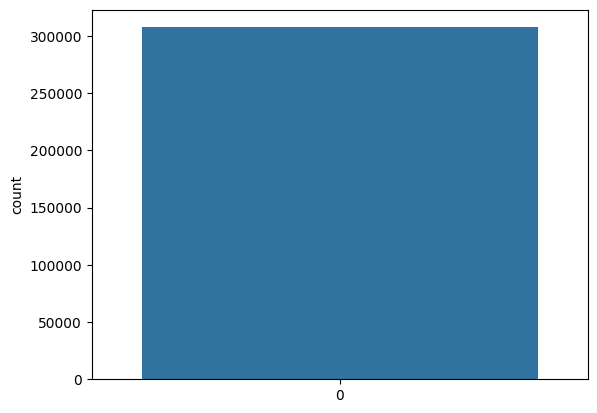

In [19]:
sns.countplot(df.CNT_FAM_MEMBERS)

There are clearly more clients with two people in the family. Therefore I will  use this value to replace the nulls.

In [20]:
df.CNT_FAM_MEMBERS = df.CNT_FAM_MEMBERS.fillna(df.CNT_FAM_MEMBERS.mode()[0])

   ### DAYS_LAST_PHONE_CHANGE

<Axes: xlabel='DAYS_LAST_PHONE_CHANGE', ylabel='Density'>

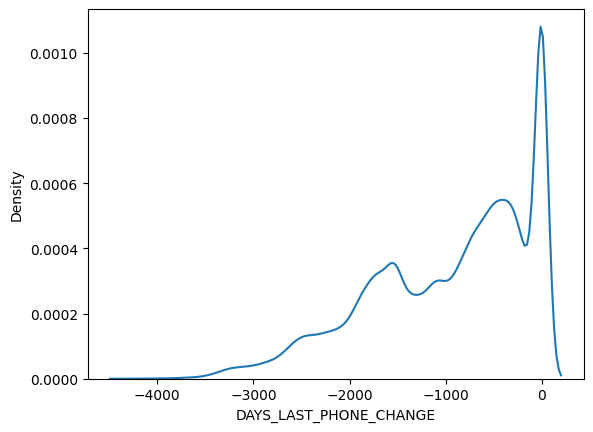

In [21]:
sns.kdeplot(df.DAYS_LAST_PHONE_CHANGE)

The distribution is somewhat skewed, so I'll make the imputation using the mode. 

In [22]:
df.DAYS_LAST_PHONE_CHANGE = df.DAYS_LAST_PHONE_CHANGE.fillna(df.DAYS_LAST_PHONE_CHANGE.mode()[0])

## AMT_ANNUITY

<Axes: xlabel='AMT_ANNUITY', ylabel='Density'>

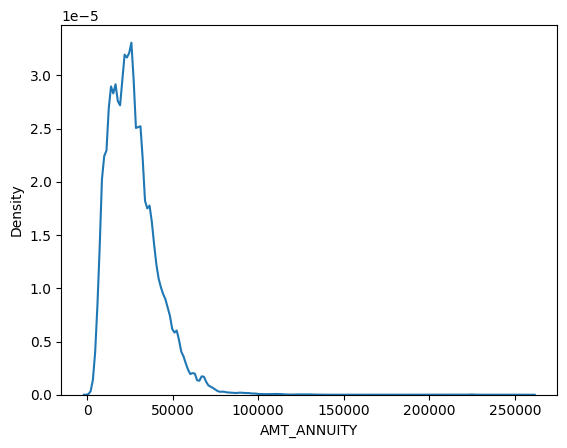

In [23]:
sns.kdeplot(df.AMT_ANNUITY)

The median value seems to be the best imputation value on this case, as the distribution is gratly skewed towards the left part.

In [24]:
df.AMT_ANNUITY = df.AMT_ANNUITY.fillna(df.AMT_ANNUITY.median())

### AMT_GOODS_PRICE

/tmp/ipykernel_83286/2067419228.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.AMT_GOODS_PRICE[pd.notnull(df.AMT_GOODS_PRICE)])


<Axes: xlabel='AMT_GOODS_PRICE', ylabel='Density'>

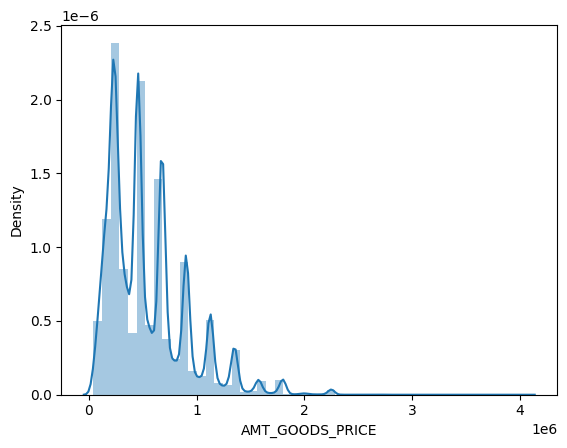

In [25]:
sns.distplot(df.AMT_GOODS_PRICE[pd.notnull(df.AMT_GOODS_PRICE)])

This one is a bit tricky. There are several peaks along the distribution. Let's impute using the mode and see if the distribution is still about the same.

/tmp/ipykernel_83286/2960561772.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.AMT_GOODS_PRICE)


<Axes: xlabel='AMT_GOODS_PRICE', ylabel='Density'>

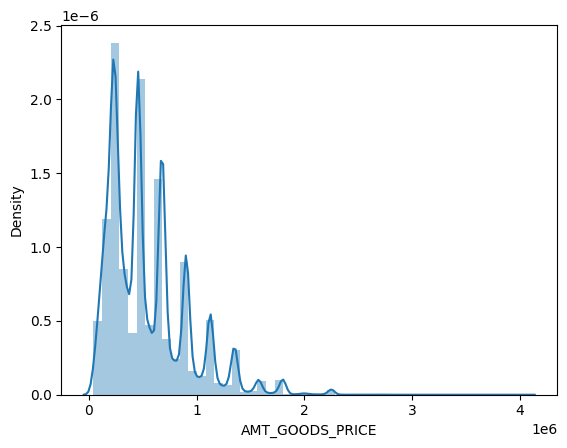

In [26]:
df.AMT_GOODS_PRICE = df.AMT_GOODS_PRICE.fillna(df.AMT_GOODS_PRICE.mode()[0])
sns.distplot(df.AMT_GOODS_PRICE)

Seems to be alright, as there were just a few missing values compared to the total number. Now  we have finished our work dealing with the missing data.

In [27]:
df.NAME_TYPE_SUITE = df.NAME_TYPE_SUITE.fillna(df.NAME_TYPE_SUITE.mode()[0])

null_values_apptr = df.isnull().sum()
null_values_apptr = null_values_apptr[null_values_apptr != 0].sort_values(ascending = False).reset_index() #only show rows with null values
null_values_apptr.columns = ["variable", "n_missing"]
null_values_apptr

,variable,n_missing
0,AMT_CREDIT_MAX_OVERDUE,204422
1,AMT_ANNUITY_BUREAU,202747
2,DAYS_ENDDATE_FACT,112803
3,AMT_CREDIT_SUM_LIMIT,107782
4,AMT_CREDIT_SUM_DEBT,46035
5,DAYS_CREDIT_ENDDATE,19211
6,AMT_CREDIT_SUM,2


## Burreau
___
Clean up of the burreau data

In [28]:
df.AMT_CREDIT_MAX_OVERDUE = df.AMT_CREDIT_MAX_OVERDUE.fillna(0)
df.AMT_CREDIT_SUM_LIMIT = df.AMT_CREDIT_SUM_LIMIT.fillna(0)
df.AMT_CREDIT_SUM_DEBT = df.AMT_CREDIT_SUM_DEBT.fillna(0)
df.AMT_CREDIT_SUM = df.AMT_CREDIT_SUM.fillna(0)
df.DAYS_CREDIT_ENDDATE = df.DAYS_CREDIT_ENDDATE.fillna(0)

df.DAYS_ENDDATE_FACT = df.DAYS_ENDDATE_FACT.fillna(df.DAYS_ENDDATE_FACT.min())


df = df.drop(columns=["AMT_ANNUITY_BUREAU"], errors="ignore")

In [29]:
null_values_apptr = df.isnull().sum()
null_values_apptr = null_values_apptr[null_values_apptr != 0].sort_values(ascending = False).reset_index() #only show rows with null values
null_values_apptr.columns = ["variable", "n_missing"]
null_values_apptr

,variable,n_missing


## Principal Component Analysis
____
Now that our data doesn't have missing values, I'm going to use a PCA to reduce the number of variables we have to deal with.

In [59]:
######################################
############### PCA ##################
######################################

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X = df.copy()
y = X['TARGET']
print("X app_train: ",X.shape)
X = X.drop(columns = ["SK_ID_CURR", "TARGET"])
print("X after drop: ",X.shape)

print("X before dummies: ",X.shape)
X = pd.get_dummies(X)

print("X after get_dummies: ",X.shape)

#scaling the components
ss = StandardScaler()
X_Scaled = ss.fit_transform(X)
print("df after fit_transform: ",X_Scaled.shape)

pca = PCA(random_state = 0)
feature_selector = pca.fit(X_Scaled)
#print("df after pca.fit: ",df.shape)
X_transformed = feature_selector.transform(X_Scaled)
print("X_transformed after pca.transform: ",X_transformed.shape)

X app_train:  (307511, 138)
X after drop:  (307511, 136)
X before dummies:  (307511, 136)
X after get_dummies:  (307511, 282)
df after fit_transform:  (307511, 282)
X_transformed after pca.transform:  (307511, 282)


In [31]:
cumulative_var = []
cumul_var = 0
for exvar in feature_selector.explained_variance_ratio_:
    cumul_var = exvar + cumul_var
    cumulative_var.append(cumul_var)

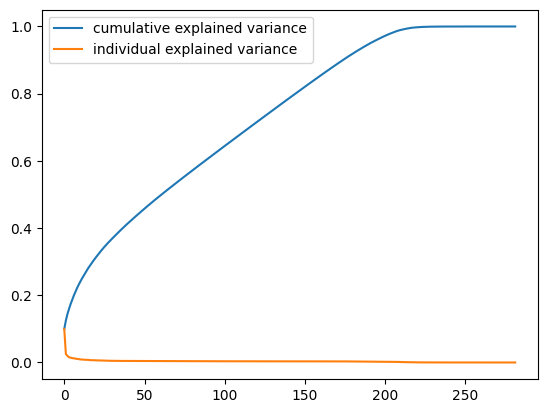

In [32]:
plt.plot(cumulative_var, label = "cumulative explained variance")
plt.plot(feature_selector.explained_variance_ratio_, label = "individual explained variance")
plt.legend();

Looking at this plot, we can see that if we want almost 100% of variance explained, we need about 200 PCs. We can further reduce this number if only around 80% of explained variance is wanted. In this case we would need "only" 150 PCs.

Now the next step is to train some models and see how they perform when compared to the LB scores. There is a lot of room for improvement by feature engineering and imputation using ML algorithms, so feel free to take this as a basic pipeline to make your own imputation/PCA analysis or just use it as it is. Hope y'all enjoy it :) 

In [64]:
pca = PCA(n_components = 150)
feature_selector = pca.fit(X_Scaled)
df_pca = feature_selector.transform(X_Scaled)
print("df after pca.transform: ",df.shape)

df after pca.transform:  (307511, 138)


In [34]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from pprint import pprint

models = []
models.append(('LR', LogisticRegression(max_iter=500)))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('LGBM', LGBMClassifier()))
#models.append(('RF', RandomForestClassifier()))
#models.append(('GB', GradientBoostingClassifier()))
#models.append(('SGD', SGDClassifier()))
results = []
names = []
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
y2 = np.ravel(y)
X = df_pca
for name, model in models:
    print ('\n========= ', name , ' =========')
    kfold = KFold(n_splits=10)
    
    cv_results = cross_validate(model, X, y2, cv=5, scoring=scoring_metrics, n_jobs=-1)
    pprint (cv_results)
    this_result = cv_results['test_accuracy']
    results.append(this_result)
    names.append(name)
    print("\n{}: accuracy : avg={:,.2f}, median={:,.2f},  std={:,.2f},  cv_results={}".format (
        name, np.mean(this_result), np.median(this_result), np.std(this_result), this_result))


=========  LR  =========
{'fit_time': array([5.15639949, 3.84209847, 4.31062269, 4.46364546, 5.23691225]),
 'score_time': array([0.09005833, 0.09964061, 0.12554264, 0.10266137, 0.09085059]),
 'test_accuracy': array([0.91914216, 0.91917336, 0.91909206, 0.9192384 , 0.91912458]),
 'test_f1': array([0.00995421, 0.01113984, 0.00994827, 0.01311345, 0.01231136]),
 'test_precision': array([0.43103448, 0.4516129 , 0.40983607, 0.48529412, 0.43661972]),
 'test_recall': array([0.00503525, 0.00563948, 0.00503525, 0.00664653, 0.00624371]),
 'test_roc_auc': array([0.73187389, 0.72711961, 0.72830985, 0.73546002, 0.73615089])}

LR: accuracy : avg=0.92, median=0.92,  std=0.00,  cv_results=[0.91914216 0.91917336 0.91909206 0.9192384  0.91912458]


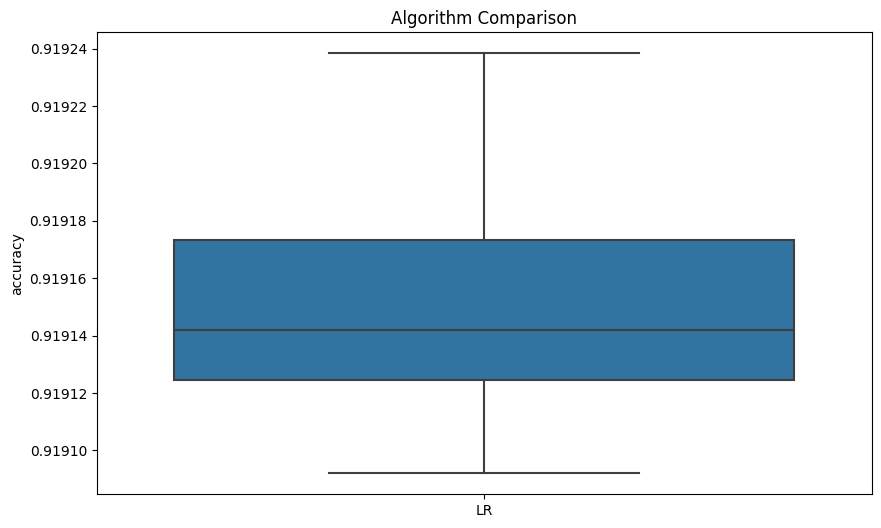

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10,6))

# boxplot algorithm comparison
if results:
    ax = sns.boxplot(data=results)
    ax.set_title('Algorithm Comparison')
    ax.set_xticklabels(names)
    ax.set_ylabel('accuracy')
    plt.show()

In [36]:
from sklearn.model_selection import train_test_split

X_train1,X_test1,y_train, y_test = train_test_split(X_Scaled, y,  test_size=0.2, random_state=123)


print ("x_train1 :" , X_train1.shape )
print ("x_test1 :", X_test1.shape)
print ("y_train :", y_train.shape)
print ("y_test :", y_test.shape)

x_train1 : (246008, 282)
x_test1 : (61503, 282)
y_train : (246008,)
y_test : (61503,)


In [37]:
X_train2 = feature_selector.transform(X_train1)

X_test2 = feature_selector.transform(X_test1)

print ("x_train1:" , X_train1.shape )
print ("x_train2 :" , X_train2.shape )
print ("x_test1:", X_test1.shape)
print ("x_test2 :", X_test2.shape)
print ("y_train :", y_train.shape)
print ("y_test :", y_test.shape)

x_train1: (246008, 282)
x_train2 : (246008, 150)
x_test1: (61503, 282)
x_test2 : (61503, 150)
y_train : (246008,)
y_test : (61503,)


In [38]:
from sklearn.metrics import roc_auc_score

algo = LGBMClassifier()
model = algo.fit(X_train2, np.ravel(y_train))

y_pred2 = model.predict (X_test2)

print ("Train accuracy 2: ", model.score(X_train2,y_train))
print ("Test accuracy 2: ", model.score(X_test2, y_test))

[LightGBM] [Info] Number of positive: 19810, number of negative: 226198
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 150
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080526 -> initscore=-2.435224
[LightGBM] [Info] Start training from score -2.435224
Train accuracy 2:  0.9201367435205359
Test accuracy 2:  0.9181503341300424


In [39]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm_labels = np.unique(y)
cm_array2 = confusion_matrix(y_test, y_pred2)
#print (cm_array)

cm_df = pd.DataFrame(cm_array2, index=cm_labels, columns=cm_labels)

[]

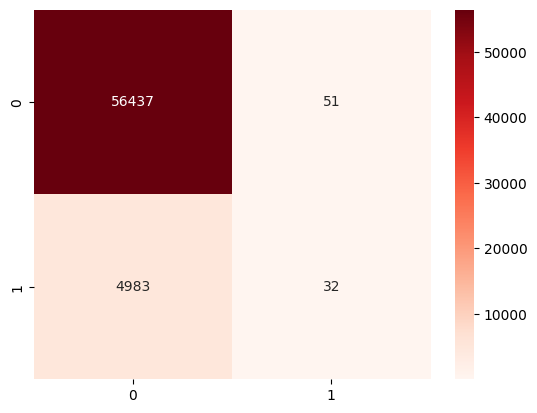

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm_df, annot=True, cmap="Reds", fmt='d').plot()

In [41]:
import numpy as np
from imblearn.over_sampling import SMOTE

oversampler= SMOTE(random_state=0)

# Creating new training set
X_train_smote, y_train_smote = oversampler.fit_resample(X_train1, y_train)


print ("x_train_smote :" , X_train_smote.shape )
print ("y_train_smote :", y_train_smote.shape)


x_train_smote : (452396, 282)
y_train_smote : (452396,)


In [42]:
y_train_smote.value_counts(normalize=True)

TARGET
1    0.5
0    0.5
Name: proportion, dtype: float64

In [43]:
X_train2 = feature_selector.transform(X_train_smote)

In [44]:
algo = LGBMClassifier()
model = algo.fit(X_train2, np.ravel(y_train_smote))

y_pred2 = model.predict (X_test2)

print ("Train accuracy 2: ", model.score(X_train2,y_train_smote))
print ("Test accuracy 2: ", model.score(X_test2, y_test))
print("AUC score: ", )

[LightGBM] [Info] Number of positive: 226198, number of negative: 226198
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 452396, number of used features: 150
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Train accuracy 2:  0.8024916223839291
Test accuracy 2:  0.7850348763474952
AUC score: 


In [45]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm_labels = np.unique(y)
cm_array2 = confusion_matrix(y_test, y_pred2)
#print (cm_array)

cm_df = pd.DataFrame(cm_array2, index=cm_labels, columns=cm_labels)

[]

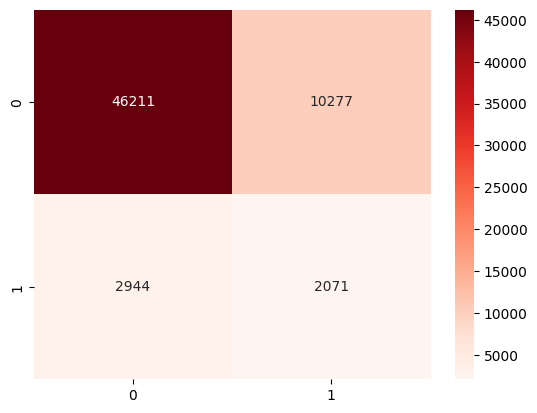

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm_df, annot=True, cmap="Reds", fmt='d').plot()

In [47]:
param_grid =  {
                    'boosting_type' : ['gbdt', 'dart', 'rf'],
                    'num_leaves' : [15, 31, 63],
                    'max_depth' : [5, 6, 7],
                    'learning_rate' : [0.01, 0.1, 0.2],
                    'n_estimators':[100, 500,1000],
                    'min_child_samples': [20,50, 100],
                    'subsample': [0.4, 0.6, 0.8],
                    'colsample_bytree' : [0.4, 0.6, 0.8],
              }

In [48]:
from sklearn.model_selection import GridSearchCV

# grid_search = GridSearchCV(estimator=LGBMClassifier(), 
#                              param_grid=param_grid, 
#                              cv = 5, 
#                              scoring='roc_auc',
#                              return_train_score=True,
#                              n_jobs = -1)

# grid_search_results = grid_search.fit (X_train2, np.ravel(y_train_smote))

In [49]:
# best_model = grid_search_results.best_estimator_
# print ("Best model : ", best_model)
# print ("Best hyper params : ", grid_search_results.best_params_)
# print ("Best score : ", grid_search_results.best_score_)

In [50]:
# grid_search_results.cv_results_

## Explainer
___
Train exaplainer for the selected model

In [65]:
import numpy as np
from alibi.explainers import AnchorTabular

In [80]:
X_exp = df.copy()
y_exp = X_exp['TARGET']
print("X_exp app_train: ", X_exp.shape)
X_exp = X_exp.drop(columns = ["SK_ID_CURR", "TARGET"])
print("X_exp after drop: ", X_exp.shape)
X_exp = pd.get_dummies(X_exp)
print("X_exp after dummies: ", X_exp.shape)

X_exp app_train:  (307511, 138)
X_exp after drop:  (307511, 136)
X_exp after dummies:  (307511, 282)


In [96]:
def credit_predict_fn(x_input) -> np.ndarray:

    x_scaled = ss.transform(x_input)
    # print("df after transform: ",x_scaled.shape)

    x_transformed = feature_selector.transform(x_scaled)
    # print("df after transform: ", x_transformed.shape)
    
    return model.predict(x_transformed)


feature_names = list(X_exp.columns)

explainer = AnchorTabular(credit_predict_fn, feature_names)

explainer.fit(X_exp.to_numpy(), disc_perc=(25, 50, 75))

X does not have valid feature names, but StandardScaler was fitted with feature names


AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (25, 50, 75)},
  'version': '0.9.4'}
)

In [98]:
idx = 1
print('Prediction: ', explainer.predictor([X_exp.iloc[idx].to_numpy()])[0])

explanation = explainer.explain(X_exp.iloc[idx].to_numpy(), threshold=0.95)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names


Prediction:  0


X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScale

Anchor: ORGANIZATION_TYPE_School > 0.00 AND NAME_EDUCATION_TYPE_Higher education > 0.00 AND NAME_TYPE_SUITE_Family > 0.00
Precision: 0.99
Coverage: 0.00


In [93]:
idx=1
print("Explainer result: ", explainer.predictor([X_exp.iloc[idx].to_numpy()]))
print("Real result: ", y_exp.iloc[idx])

df after transform:  (1, 282)
df after transform:  (1, 150)
Explainer result:  [0]
Real result:  0


X does not have valid feature names, but StandardScaler was fitted with feature names
